<a href="https://colab.research.google.com/github/miladqolamee/NeuroMatch_2022_group_project/blob/main/Coding_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is created for exploratory data analysis on Allen 2P dataset by **Pierogi All Stras** 

---
# A brief summary of Allen 2P Experiment Design


- Single and multiple-plane 2 photon calcium imaging was used.
- Exitatory and inhibitory populaiton of nuerons were imaged in different cre-lines.
- Each population was imaged over multiple days and under different experimental conditions (with familiar, novel stimuli and under active and passive veiwing conditions)
- This dataset can be used to evaluate the influence of experience, expectation and task engagemen on neural coding and dynamics.
- Overal, we have 82 mouse, 3021 behavioral sessions and 551 imaging sessions. In total 34619 cells were recorded.
- Mice performed a go/no go visual change detection task. Visual stimui were presented continuously for 1 hour. The start of trial was not indicated and mouse was free to run.

For more information see:
[Link](https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html).

# Experimental setup 

<img src="https://github.com/miladqolamee/NeuroMatch_2022_group_project/blob/main/Allen%20viewing%20condition.png?raw=1" alt="Experimental setup" class="bg-primary" width="75%">

---
# A brief summary of Allen 2P Dataset
To access data in the dataset we can instal `allensdk` package. By using `AllenBehaviorOphysProjectCache` object and its methods in this package we can access desired data. 

In the dataset we have 3 tables and 2 datasets streams. We should use informatin inside the table to extract our desired subset of information. These 3 tables are:

1) Behavior Sessions Table: Contains metadata for behavioral sessions (both trianing session and also sessions whcih imaging was perfomed). This table can be accessed by `get_behavior_session_talbe()` method.

2) Ophys Sessions Table: Contains metadata and experimental conditions for all sessions. This talbe can accessed by `get_ophys_session_table()` method.

3) Ophys Experiments Table: Contains metadata and experimental conditions fo all imaging experiment (aka imaging plane). This table can be accessed by `get_experiment_session_table()` method.

For more information see:
[Link](https://github.com/miladqolamee/NeuroMatch_2022_group_project/blob/main/VBP_WhitePaper_SDK_Documentation.pdf).

# Allen 2P dataset terminology

<img src="https://allensdk.readthedocs.io/en/latest/_static/visual_behavior_2p/data_structure.png" alt="dataset terminology" class="bg-primary" width="100%">

---
# First instal `mindscope_utilities` package which includes `allensdk` package and some other useful functions for our data analyis

In [ ]:
!pip install pip --upgrade --quiet
!pip install mindscope_utilities --quiet

In [76]:
#  @title Improt relevant packages
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from pathlib import Path

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

## First we need a file path because we need to pass it to cache object to indicate where the file should be downloaded

## By calling `VisualBehaviorOphysProjectCache`, Tables will be downloaded

In [ ]:
# Update this to a valid directory in your filesystem
data_storage_directory = Path("/local1/visual_behavior_ophys_cache_dir")

cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

## Experiment Sessions Table

In [ ]:
experiment_table = cache.get_ophys_experiment_table()   # Getting Experiment Session Table
experiment_table.sample(5)                              # Show 5 random observation
print(len(experiment_table))                            # How many rows?
print(len(experiment_table.ophys_session_id.unique()))  # How many unique imaging session

## Selecting experiments for VIP and SST nuerons

In [30]:
experiment_variables = experiment_table.columns      # All variables in behavior table

experiment_table.cre_line.unique()    # How many unique cre-line we have

Vip_experiment_table = experiment_table[(experiment_table.cre_line.values == 'Vip-IRES-Cre') & 
                                    (experiment_table.ophys_session_id.isnull() == False)]
Sst_experiment_table = experiment_table[(experiment_table.cre_line.values == 'Sst-IRES-Cre') & 
                                    (experiment_table.ophys_session_id.isnull() == False)]


# getting information just for one mouse for simplification and sort its table by date of aquisition
Vip_mouse_id = Vip_experiment_table.mouse_id.unique()[0]
Sst_mouse_id = Sst_experiment_table.mouse_id.unique()[0]

this_mouse_Vip_experiment_table = experiment_table[(experiment_table.cre_line.values == 'Vip-IRES-Cre') & 
                                    (experiment_table.ophys_session_id.isnull() == False)
                                    & (experiment_table.mouse_id.values == Vip_mouse_id)].sort_values(
                                        by = 'date_of_acquisition')
this_mouse_Sst_experiment_table = experiment_table[(experiment_table.cre_line.values == 'Sst-IRES-Cre') & 
                                    (experiment_table.ophys_session_id.isnull() == False)
                                    & (experiment_table.mouse_id.values == Sst_mouse_id)].sort_values(
                                        by = 'date_of_acquisition')



,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,...,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,experience_level,passive,image_set,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
792815735,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,148.0,Vip-IRES-Cre,GCaMP6f,1.0,...,791352433,VisualBehavior,175,VISp,2018-12-10 21:19:50.000000,OPHYS_1_images_A,Familiar,False,A,859887405
795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,Vip-IRES-Cre,GCaMP6f,3.0,...,791352433,VisualBehavior,175,VISp,2018-12-13 21:11:17.000000,OPHYS_3_images_A,Familiar,False,A,859887459
795953296,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,152.0,Vip-IRES-Cre,GCaMP6f,4.0,...,791352433,VisualBehavior,175,VISp,2018-12-14 20:17:05.000000,OPHYS_4_images_B,Novel 1,False,B,859887431
796108483,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,153.0,Vip-IRES-Cre,GCaMP6f,5.0,...,791352433,VisualBehavior,175,VISp,2018-12-15 20:56:37.000000,OPHYS_5_images_B_passive,Novel >1,True,B,859888310
796308505,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,154.0,Vip-IRES-Cre,GCaMP6f,6.0,...,791352433,VisualBehavior,175,VISp,2018-12-16 20:44:48.000000,OPHYS_6_images_B,Novel >1,False,B,859887448
798404219,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,156.0,Vip-IRES-Cre,GCaMP6f,2.0,...,791352433,VisualBehavior,175,VISp,2018-12-18 23:26:29.000000,OPHYS_2_images_A_passive,Familiar,True,A,859888258


For this specific Vip mouse we have six imaging session sorted by date of aquisition. In `session_type` column it can be seen what type of image was presented and what kind of task (active or passive ) was performed. 
In the next cell we want to compare the neural response around stimulus omittion during active and passive task.

In [31]:
# getting passive and active experiment ids for this mouse (just one active and one passive session where "image_B" was presented)
this_mouse_Vip_passive_experiment_id = this_mouse_Vip_experiment_table[this_mouse_Vip_experiment_table.session_type.str.contains("passive")].index[0]
this_mouse_Vip_active_experiment_id = this_mouse_Vip_experiment_table[~this_mouse_Vip_experiment_table.session_type.str.contains("passive")].index[2]


# loading experiment dataset 
this_mouse_Vip_passive_experiment = cache.get_behavior_ophys_experiment(this_mouse_Vip_passive_experiment_id)
this_mouse_Vip_active_experiment = cache.get_behavior_ophys_experiment (this_mouse_Vip_active_experiment_id)

Look at the performance of these two sessions (one active and the other passive)  
* You can run each line or varialble of the code by highlighting it and then press `control` + `shift`+ `inter`

In [ ]:
this_mouse_Vip_passive_experiment.get_performance_metrics()   # perfomance metrics of this passice session
this_mouse_Vip_active_experiment.get_performance_metrics()    # perfomance metrics of this active session


Looking at identified cells in these experiment

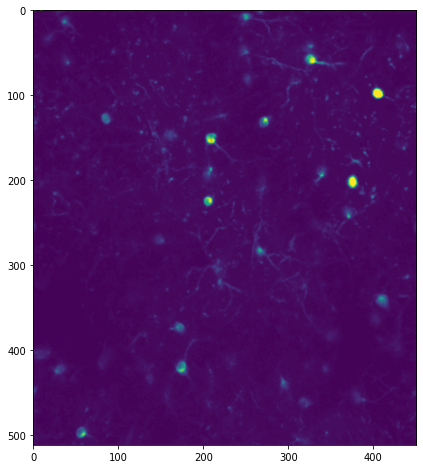

In [74]:
from IPython.core.pylabtools import figsize
# First take a look at cell_specimen_id table which contains information about identified cells in this scecimen
this_mouse_Vip_passive_experiment.cell_specimen_table.head()
this_mouse_Vip_active_experiment.cell_specimen_table.head()

# Then lets visualize the specimen 
plt.imshow(this_mouse_Vip_passive_experiment.max_projection)
plt.rcParams['figure.figsize'] = [15, 8]

Loading all neural data into a pandas 'tidy' format

In [96]:
this_mouse_Vip_passive_neural_data = ophys.build_tidy_cell_df(this_mouse_Vip_passive_experiment)

# How many cells we have?
print(f'We have: {len(this_mouse_Vip_passive_neural_data.cell_roi_id.unique())} unique cells in this experiment')



We have: 44 unique cells in this experiment


In the next cell we want to choose one of the cells and extract timestams for that cell during the the entire experiment

In [105]:
cell_id = this_mouse_Vip_passive_neural_data.cell_roi_id.unique()[1]
this_mouse_Vip_passive_neural_data_single_cell = this_mouse_Vip_passive_neural_data.query('cell_roi_id == @cell_id')
this_mouse_Vip_passive_neural_data_single_cell.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id
0,2.93037,0.829621,0.0,0.0,1080899917,1086491308
1,2.96268,1.148210,0.0,0.0,1080899917,1086491308
2,2.99499,0.882873,0.0,0.0,1080899917,1086491308
3,3.02730,1.037061,0.0,0.0,1080899917,1086491308
4,3.05961,1.022145,0.0,0.0,1080899917,1086491308


Finally our first plot!

We want to plot dff (fluorescence signal) against time

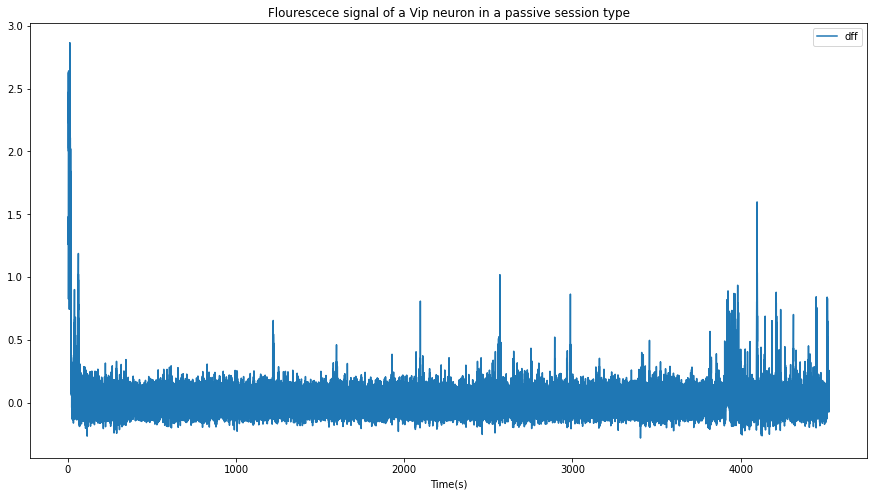

In [115]:
this_mouse_Vip_passive_neural_data_single_cell.plot(
    x = 'timestamps',
    y = 'dff'
)
plt.xlabel('Time(s)')
plt.title('Flourescece signal of a Vip neuron in a passive session type')
plt.show()


In [ ]:
#Just a code that might help later on
#M='M'
#behavior_table.query('sex == @ M')
#This way we can specifically ask for the data containing these parameters. the mouse only being male (which is better since female mices' results aren't as reliable)